# Simulate open system dynamics
**Calculating the dynamics of a quantum system described by a GKS–Lindblad master equation**

The Q-CTRL Python package enables you to simulate not only the evolution of isolated quantum systems (see the [Simulate quantum dynamics](https://docs.q-ctrl.com/boulder-opal/user-guides/simulate-quantum-dynamics) user guide), but also the evolution of systems that are interacting with their environment. You can express the dynamics of these open quantum systems in terms of a master equation, such as the one described by [Gorini, Kossakowski, and Sudarshan (GKS)](https://doi.org/10.1063/1.522979) and [Lindblad](https://doi.org/10.1007/BF01608499). The tools described in this user guide allow you to solve this GKS–Lindblad master equation to obtain the time evolution for the system that you want.

## Import and initialization

All usage of the Q-CTRL Python package begins by importing the `qctrl` package and starting a session.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import coo_matrix
from qctrlopencontrols import new_corpse_control, new_primitive_control
from qctrlvisualizer import get_qctrl_style, plot_controls

from qctrl import Qctrl

plt.style.use(get_qctrl_style())

# Start a session with the API
qctrl = Qctrl()

## Worked example: Simulating a single-qubit open system

The master equation integration tool from the Q-CTRL Python package allows you to obtain the solution of a GKS–Lindblad equation. This equation describes the evolution of a system that obeys a system Hamiltonian $H_{\rm s}$ and also any number of extra Lindbladian terms consisting of a rate $\gamma_i$ and a Lindblad operator $L_i$:

$$ \frac{\mathrm{d} \rho(t)}{\mathrm{d} t} = - i \left[ H_{\rm s}(t), \rho(t) \right] + \sum_i \gamma_i \left[ L_i \rho(t) L_i^\dagger - \frac{1}{2} \rho(t) L_i^\dagger L_i - \frac{1}{2} L_i^\dagger L_i  \rho(t) \right]. $$

For this example, consider a single-qubit system whose evolution you can control through a complex Rabi rate $\Omega(t)$ and a detuning $\Delta(t)$, so that the system Hamiltonian is:

$$ H_{\rm s}(t) = \frac{1}{2} \Omega(t) \sigma_- + \frac{1}{2} \Omega^* (t) \sigma_+ + \Delta(t) \sigma_z, $$

where $\sigma_x$, $\sigma_y$, and $\sigma_z$ are the Pauli matrices and $\sigma_\pm = (\sigma_x \mp i \sigma_y)/2$.

Suppose this system is also subject to $T_2$ noise, which you can represent by the Lindblad operator $L= \sigma_z$ with associated rate $\gamma = 1/(2T_2)$. By using the tools from the Q-CTRL Python package to solve this master equation, you can obtain the evolution of the system in terms of $\rho(t)$.

### Creating the pulse

The first step is to set up the Python object that represents the pulse, which you can define by yourself or by importing one of the predefined pulses in the Q-CTRL Open Controls package. In particular, this example illustrates the case where the target operation is an $X_{\pi}$ rotation applied to a system initially at the state $\left|0\right\rangle$, which corresponds to the initial density matrix $\rho(0) = \left| 0 \right\rangle \left\langle 0 \right|$. Such an operation should flip the qubit from the state $\left|0\right\rangle$ to the state $\left|1\right\rangle$.

In [2]:
# Define standard matrices.
identity = np.identity(2, dtype=np.complex)
sigma_x = np.array([[0.0, 1.0], [1.0, 0.0]], dtype=np.complex)
sigma_z = np.array([[1.0, 0.0], [0.0, -1.0]], dtype=np.complex)
sigma_m = np.array([[0.0, 1.0], [0.0, 0.0]], dtype=np.complex)

# Define control parameters.
omega_max = 2 * np.pi * 1e6  # Hz
total_rotation = np.pi
initial_state = np.array([[1], [0]], dtype=np.complex)
initial_density_matrix = np.kron(initial_state, initial_state.T.conj())

# Obtain predefined pulse from Q-CTRL Open Controls.
predefined_pulse = new_primitive_control(
    rabi_rotation=total_rotation,
    azimuthal_angle=0.0,
    maximum_rabi_rate=omega_max,
)

### Creating the graph

To describe the dynamics of an open system with the Q-CTRL Python package, you start by setting up a graph object as described in the [Set up quantum systems](https://docs.q-ctrl.com/boulder-opal/user-guides/set-up-quantum-systems) user guide. The difference is that besides setting up a graph with a piecewise-constant system Hamiltonian $H_{\rm s} (t)$ for the controls, you must also define the Lindblad terms that appear in the GKS–Lindblad master equation:

$$ \frac{\mathrm{d}}{\mathrm{d} t} \rho(t) = - i \left[ H_{\rm s} (t), \rho(t) \right] + \gamma L \rho(t) L^\dagger - \frac{1}{2} \gamma \rho(t) L^\dagger L - \frac{1}{2} \gamma L^\dagger L \rho(t). $$

If you provide a tuple with the rate $\gamma$ and Lindblad operator $L$ as `lindblad_terms` to the operation [`qctrl.operations.density_matrix_evolution_pwc`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Operations/density_matrix_evolution_pwc.html), together with a piecewise constant `hamiltonian` and an `initial_density_matrix`, you obtain the value of the density matrix $\rho(t)$ for the `sample_times` that you requested. The code block below illustrates how you can do that in a call of the function [`qctrl.functions.calculate_graph`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Functions/calculate_graph.html). It also performs the same operation for a closed system (which takes into account the system Hamiltonian, but not the Lindbladian), so you can compare the two types of evolution.

Note that the `density_matrix_evolution_pwc` function can be inefficient when used with the default parameters if the dimension of your Hilbert space is more than roughly $10$. An example later in this guide shows how you can change the parameters to perform a more efficient computation for large systems.

In [3]:
# Define time parameters of the simulation.
duration = sum(predefined_pulse.durations)
sample_times = np.linspace(0, duration, 100)

# Set up simulation graph.
with qctrl.create_graph() as graph:
    # Define the controls using the predefined pulse.
    omega = qctrl.operations.tensor_pwc(
        values=predefined_pulse.rabi_rates
        * np.exp(1j * predefined_pulse.azimuthal_angles),
        durations=predefined_pulse.durations,
    )
    delta = qctrl.operations.tensor_pwc(
        values=predefined_pulse.detunings, durations=predefined_pulse.durations
    )

    # Define terms of the Hamiltonian.
    sigma_m_term = qctrl.operations.pwc_operator(signal=omega, operator=sigma_m)
    sigma_z_term = qctrl.operations.pwc_operator(signal=delta, operator=sigma_z)
    sigma_x_term = qctrl.operations.pwc_operator_hermitian_part(operator=sigma_m_term)
    hamiltonian = qctrl.operations.pwc_sum([sigma_x_term, sigma_z_term])

    # Define Lindblad term of the master equation.
    lindblad_operator = sigma_z
    T2 = 1e-6  # s

    # Calculate density matrix evolution according to the master equation.
    qctrl.operations.density_matrix_evolution_pwc(
        initial_density_matrix=initial_density_matrix,
        hamiltonian=hamiltonian,
        lindblad_terms=[(1 / (2 * T2), lindblad_operator)],
        sample_times=sample_times,
        name="open_system_states",
    )

    # Calculate vector state evolution for a closed system.
    qctrl.operations.matmul(
        qctrl.operations.time_evolution_operators_pwc(
            hamiltonian=hamiltonian,
            sample_times=sample_times,
        ),
        initial_state,
        name="closed_system_states",
    )

# Run simulation.
results = qctrl.functions.calculate_graph(
    graph=graph,
    output_node_names=["closed_system_states", "open_system_states"],
)

Your task calculate_graph has completed in 3s.


### Plotting the system evolution

After you obtain the evolution of the system with and without $T_2$ noise, you can plot the results at each of the `sample_times` that you requested to see how the system goes from the initial state $\left|0\right\rangle$ to the target state $\left| 1 \right\rangle$. While the evolution for a closed system leads perfectly to the desired final state, the open system evolution is disrupted by the presence of $T_2$ noise.

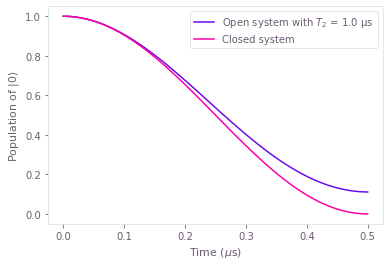

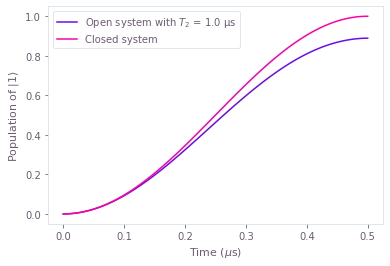

In [4]:
plt.figure()
plt.xlabel(f"Time ($\mu$s)")
plt.ylabel(r"Population of $| 0 \rangle$")
plt.plot(
    sample_times * 1e6,
    np.abs(
        [
            density_matrix[0][0]
            for density_matrix in results.output["open_system_states"]["value"]
        ]
    ),
    label=f"Open system with $T_2$ = {T2*1e6} μs",
)
plt.plot(
    sample_times * 1e6,
    np.abs(
        [
            state_vector[0][0]
            for state_vector in results.output["closed_system_states"]["value"]
        ]
    )
    ** 2,
    label="Closed system",
)
plt.legend()

plt.figure()
plt.xlabel(f"Time ($\mu$s)")
plt.ylabel(r"Population of $| 1 \rangle$")
plt.plot(
    sample_times * 1e6,
    np.abs(
        [
            density_matrix[1][1]
            for density_matrix in results.output["open_system_states"]["value"]
        ]
    ),
    label=f"Open system with $T_2$ = {T2*1e6} μs",
)
plt.plot(
    sample_times * 1e6,
    np.abs(
        [
            state_vector[1][0]
            for state_vector in results.output["closed_system_states"]["value"]
        ]
    )
    ** 2,
    label="Closed system",
)
plt.legend()

plt.show()

### Summary

The open-system tools from the Q-CTRL Python package allow you to use the graph framework to calculate more general types of system evolution. While the tools described in the [Simulate quantum dynamics](https://docs.q-ctrl.com/boulder-opal/user-guides/simulate-quantum-dynamics) user guide show how you can obtain the evolution of a system that follows the Schrödinger equation, the open system tools allow you to solve a more general master equation. You can also use these tools in optimization graphs, if you have a cost function that represents what you want to optimize.

## Example: Quasi-static scan of a system exposed to $T_1$ noise

The quasi-static scans described in the [Quasi-static error susceptibility](https://docs.q-ctrl.com/boulder-opal/user-guides/calculate-quasi-static-error-susceptibility) user guide are useful to compare the performance of pulses against noise of different strengths. That user guide explains how you can calculate the quasi-static scan for a closed quantum system that evolves according to the Schrödinger equation. To create quasi-static scans for a system that evolves according to a master equation, you need to employ the graph framework to obtain the points that compose the quasi-static scan.

For this example, consider a system under the following system Hamiltonian:

$$ H_{\rm s}(t) = \frac{1}{2} \Omega(t) \sigma_- + \frac{1}{2} \Omega^* (t) \sigma_+ + \eta \sigma_z, $$

where $\sigma_x$, $\sigma_y$, and $\sigma_z$ are the Pauli matrices and $\sigma_\pm = (\sigma_x \mp i \sigma_y)/2$. The signal $\Omega(t)$ represents your complex-valued controls, while $\eta$ is the noise coefficient. Assuming this noise changes sufficiently slowly that it is constant in each run of the gate, each point of the quasi-static scan represents the performance of the pulse under different strengths of $\eta$.

To quantify the performance of the pulse, you can use the state infidelity as a metric. Using the fact that the target state is a pure state $\rho_{\rm target}$, you can find the infidelity of a pulse that evolves the system to a state $\rho(t)$ through the formula:

$$ \mathcal{I} (t) = 1 - \left( \mathrm{Tr} \left\{ \sqrt{ \sqrt{\rho_{\rm target}} \rho(t) \sqrt{\rho_{\rm target}} } \right\} \right)^2  = 1 - \mathrm{Tr} \left\{ \rho_{\rm target} \rho(t) \right\}. $$

Consider as well that the system can decay at a certain rate $T_1$, so that the complete GKS–Lindblad master equation that describes its evolution is:

$$ \frac{\mathrm{d}}{\mathrm{d} t} \rho(t) = - i \left[ H_{\rm s}(t), \rho(t) \right] + \frac{1}{T_1} \sigma_- \rho(t) \sigma_+ - \frac{1}{2} \frac{1}{T_1} \left\{ \rho(t), \sigma_+ \sigma_- \right\}. $$

In this master equation, $\sigma_-$ is the Lindblad operator with an associated rate $1/T_1$.

To see how a set of pulses performs against additive $\sigma_z$ noise, when also subject to $T_1$ noise, you can use the open system tools to calculate the evolution of the master equation for different values of quasi-static noise $\eta$. This example shows how you can create an [optimized pulse](https://docs.q-ctrl.com/boulder-opal/user-guides/optimize-controls) under these conditions by setting the sum of the infidelities under different quasi-static strengths as the cost function of the optimization. The code block below compares the performance of the predefined pulse and the optimized pulse, plotting the shape of the controls and the quasi-static scans for both of them.

Your task calculate_optimization has started.
Your task calculate_optimization has completed in 199s.


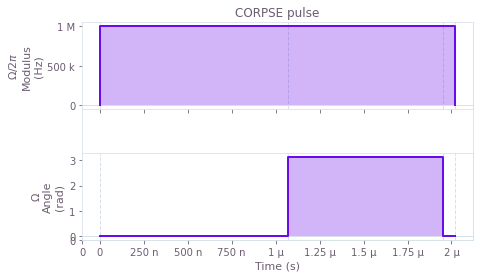

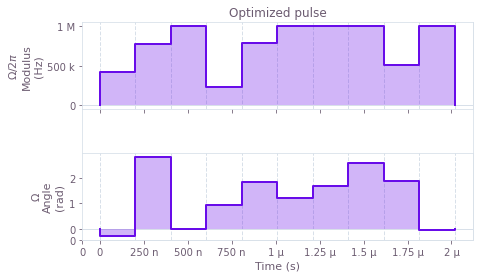

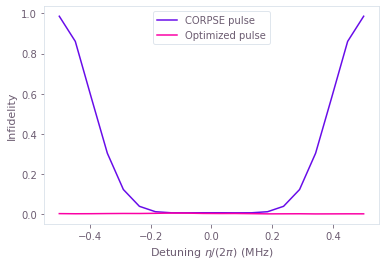

In [5]:
# Define standard matrices.
identity = np.identity(2, dtype=np.complex)
sigma_x = np.array([[0.0, 1.0], [1.0, 0.0]], dtype=np.complex)
sigma_z = np.array([[1.0, 0.0], [0.0, -1.0]], dtype=np.complex)
sigma_m = np.array([[0.0, 1.0], [0.0, 0.0]], dtype=np.complex)

# Define noise and control parameters.
T1 = 100e-6  # s
omega_max = 2 * np.pi * 1e6  # Hz
total_rotation = np.pi / 2
target_operator = (identity - 1j * sigma_x) / np.sqrt(2)
initial_density_matrix = np.array([[1, 0], [0, 0]], dtype=np.complex)
target_density_matrix = (
    target_operator @ initial_density_matrix @ target_operator.T.conj()
)

# Define scan parameters
scan_point_count = 20
scan_range = np.linspace(-omega_max / 2, omega_max / 2, scan_point_count)

# Obtain predefined pulse from Q-CTRL Open Controls.
corpse_pulse = new_corpse_control(
    rabi_rotation=total_rotation,
    azimuthal_angle=0.0,
    maximum_rabi_rate=omega_max,
)
duration = sum(corpse_pulse.durations)


def state_infidelity(density_matrix, name):
    """
    Calculates the state infidelity of the `density_matrix` with respect to the
    `target_density_matrix`, which represents a pure state.
    """
    return qctrl.operations.abs(
        1
        - qctrl.operations.trace(
            qctrl.operations.matmul(target_density_matrix, density_matrix)
        ),
        name=name,
    )


# Set up optimization graph.
with qctrl.create_graph() as graph:
    # Define the controls for the predefined pulse.
    corpse_omega = qctrl.operations.tensor_pwc(
        values=corpse_pulse.rabi_rates * np.exp(1j * corpse_pulse.azimuthal_angles),
        durations=corpse_pulse.durations,
        name="corpse_pulse",
    )

    # Define controls for the optimized pulse.
    optimized_omega = qctrl.operations.complex_pwc_signal(
        moduli=qctrl.operations.bounded_optimization_variable(10, 0, omega_max),
        phases=qctrl.operations.unbounded_optimization_variable(10, 0, 2 * np.pi),
        duration=duration,
        name="optimized_pulse",
    )

    # Create control Hamiltonians for the predefined pulse and the optimized pulse.
    noiseless_corpse_hamiltonian = qctrl.operations.pwc_operator_hermitian_part(
        operator=qctrl.operations.pwc_operator(signal=corpse_omega, operator=sigma_m)
    )
    noiseless_optimized_hamiltonian = qctrl.operations.pwc_operator_hermitian_part(
        operator=qctrl.operations.pwc_operator(signal=optimized_omega, operator=sigma_m)
    )

    # Create list of detuning terms for the quasi-static scan.
    scan_terms = [
        qctrl.operations.constant_pwc_operator(
            operator=amplitude * sigma_z, duration=duration
        )
        for amplitude in scan_range
    ]

    # Add detuning terms to the control Hamiltonians.
    corpse_hamiltonians = [
        qctrl.operations.pwc_sum([noiseless_corpse_hamiltonian, scan_term])
        for scan_term in scan_terms
    ]
    optimized_hamiltonians = [
        qctrl.operations.pwc_sum([noiseless_optimized_hamiltonian, scan_term])
        for scan_term in scan_terms
    ]

    # Define decay term of the master equation.
    lindblad_operator = sigma_m

    # Calculate the final density matrices from the master equation.
    corpse_density_matrices = [
        qctrl.operations.density_matrix_evolution_pwc(
            initial_density_matrix=initial_density_matrix,
            hamiltonian=corpse_hamiltonian,
            lindblad_terms=[(1 / T1, lindblad_operator)],
            sample_times=np.array([duration]),
        )[-1]
        for corpse_hamiltonian in corpse_hamiltonians
    ]
    optimized_density_matrices = [
        qctrl.operations.density_matrix_evolution_pwc(
            initial_density_matrix=initial_density_matrix,
            hamiltonian=optimized_hamiltonian,
            lindblad_terms=[(1 / T1, lindblad_operator)],
            sample_times=np.array([duration]),
        )[-1]
        for optimized_hamiltonian in optimized_hamiltonians
    ]

    # Calculate infidelities with respect to the target.
    corpse_infidelities = [
        state_infidelity(
            density_matrix=density_matrix,
            name=f"corpse_infidelity{number}",
        )
        for number, density_matrix in enumerate(corpse_density_matrices)
    ]
    optimized_infidelities = [
        state_infidelity(
            density_matrix=density_matrix,
            name=f"optimized_infidelity{number}",
        )
        for number, density_matrix in enumerate(optimized_density_matrices)
    ]

    # Create cost as the sum of all the infidelities of the optimized pulse.
    qctrl.operations.sum(optimized_infidelities, name="cost")

# Run optimization.
results = qctrl.functions.calculate_optimization(
    graph=graph,
    cost_node_name="cost",
    output_node_names=["corpse_pulse", "optimized_pulse"]
    + [f"corpse_infidelity{number}" for number in range(scan_point_count)]
    + [f"optimized_infidelity{number}" for number in range(scan_point_count)],
)

# Plot pulses.
fig = plt.figure()
plt.title("CORPSE pulse")
plt.xticks(([0]))
plt.yticks(([0]))
plot_controls(fig, {r"$\Omega$": results.output[f"corpse_pulse"]})
fig2 = plt.figure()
plt.title("Optimized pulse")
plt.xticks(([0]))
plt.yticks(([0]))
plot_controls(fig2, {r"$\Omega$": results.output[f"optimized_pulse"]})

# Plot quasi-static scan.
fig3 = plt.figure()
plt.xlabel(r"Detuning $\eta$/(2$\pi$) (MHz)")
plt.ylabel("Infidelity")
plt.plot(
    scan_range * 1e-6 / (2 * np.pi),
    np.array(
        [
            results.output[f"corpse_infidelity{number}"]["value"]
            for number in range(scan_point_count)
        ]
    ),
    label="CORPSE pulse",
)
plt.plot(
    scan_range * 1e-6 / (2 * np.pi),
    [
        results.output[f"optimized_infidelity{number}"]["value"]
        for number in range(scan_point_count)
    ],
    label="Optimized pulse",
)
plt.legend()
plt.show()

## Example: Simulating large systems

The previous examples show how you can perform efficient simulations and optimizations of open quantum systems in small Hilbert spaces. However, for larger systems, with Hilbert space dimensions more than roughly $10$, the exact evolution calculated in those examples can be prohibitively expensive to compute. Instead, you can get better performance by using an approximate method to calculate the evolution.

The Q-CTRL Python package makes it easy to switch between the exact and approximate methods, simply by passing the `krylov_subspace_dimension` parameter to the [`qctrl.operations.density_matrix_evolution_pwc`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Operations/density_matrix_evolution_pwc.html) function. This parameter controls the precision of the method: a higher value leads to a more accurate solution, at the expense of computational efficiency. The Q-CTRL Python package also provides a function [`qctrl.operations.estimated_krylov_subspace_dimension_arnoldi`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Operations/estimated_krylov_subspace_dimension_arnoldi.html) to estimate a value for this parameter based on properties of your system and your desired error tolerance. Note, however, that this estimate can sometimes be unnecessarily high; for performance-critical applications, for example when performing optimizations, you can manually fine-tune the parameter via preliminary simulations in order to find a smaller value that still yields sufficiently small errors.

When you pass a `krylov_subspace_dimension`, you also have the option of setting up your system with sparse matrices. Using sparse matrices can lead to performance improvements if your Hamiltonian and collapse operators contain mostly zeros.

In this example, we show how to use both sparse matrices and a `krylov_subspace_dimension` to perform an efficient simulation of a larger open quantum system. In particular, we consider a superconducting qubit coupled to a transmission line resonator (truncated to $10$ levels), with a drive on the resonator. We show how to simulate a measurement process that uses the quadratures of the resonator output to probe the qubit state.

Assuming that the qubit is far detuned from the resonator (the dispersive approximation), and that the resonator drive is off resonance from the qubit transition frequency, in the absence of losses the system can be described by the Hamiltonian (see [Gambetta et al.](https://arxiv.org/pdf/0709.4264.pdf) and [Blais et al.](https://arxiv.org/pdf/cond-mat/0402216.pdf)):

$$ H(t) = \frac{\omega_q+g^2/\Delta}{2} \sigma_z + (\omega_r-\omega_d) a^\dagger a + \frac{g^2}{\Delta} a^\dagger a \sigma_z + \Gamma(t) a^\dagger + \Gamma^*(t) a, $$

where $a$ is the annihilation operator for the resonator, $\sigma_z$ is the Pauli Z matrix for the qubit, $\Gamma(t)$ is the resonator drive, $\omega_r$ is the resonator frequency, $\omega_q$ is the qubit transition frequency, $\omega_d$ is the resonator drive frequency, $\Delta=\omega_q-\omega_r$ is the qubit detuning from the resonator, and $g$ is the coupling strength. Taking into account the photon loss $\kappa$ for the resonator and qubit decay $\gamma$, the system evolution follows the GKS–Lindblad equation:

$$ \frac{\mathrm{d} \rho(t)}{\mathrm{d} t} = - i \left[ H(t), \rho(t) \right] + \kappa \left[ a \rho(t) a^\dagger - \frac{1}{2} \rho(t) a^\dagger a - \frac{1}{2} a^\dagger a  \rho(t) \right] +
\gamma \left[ \sigma_- \rho(t) \sigma_+ - \frac{1}{2} \rho(t) \sigma_+ \sigma_- - \frac{1}{2} \sigma_+\sigma_-  \rho(t) \right], $$

where $\sigma_{\pm} = (\sigma_x \mp i\sigma_y)/2$.

Below we show how you can simulate this system using BOULDER OPAL. Note that similar code can be used to perform optimizations, for example if you want to design custom measurement pulses optimized for your particular system.

Your task calculate_graph has completed in 4s.
Estimated Krylov subspace dimension: 22


Your task calculate_graph has started.
Your task calculate_graph has completed in 22s.


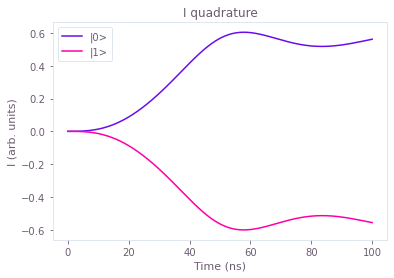

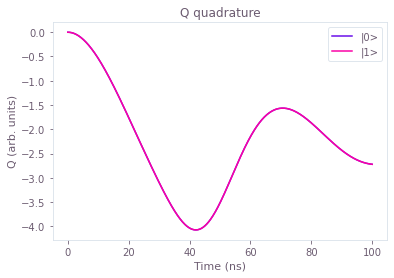

In [6]:
# Define standard matrices.
identity_q = np.identity(2, dtype=np.complex)
sigma_z = np.array([[1.0, 0.0], [0.0, -1.0]], dtype=np.complex)
sigma_m = np.array([[0.0, 1.0], [0.0, 0.0]], dtype=np.complex)

n_r = 10  # 10 levels in the resonator
identity_r = np.identity(n_r, dtype=np.complex)
a = np.diag(np.sqrt(np.arange(1, n_r)), k=1)

# Define system parameters.
omega_r = 2 * np.pi * 10  # GHz
omega_q = 2 * np.pi * 8  # GHz
omega_d = 2 * np.pi * 10  # GHz
delta = omega_q - omega_r
g = 2 * np.pi * 0.05  # GHz
kappa = 2 * np.pi * 10e-3  # GHz
gamma = 2 * np.pi * 10e-6  # GHz
duration = 100  # ns

# Define drive parameters.
drive_amplitude = 2 * np.pi * 0.02  # GHz
drive_rise_duration = 20  # ns
segment_count = 1000

# Set up Hamiltonian. We use the `coo_matrix` function from SciPy to
# convert the matrix to a sparse matrix, which can lead to faster
# computations for large systems.
base_hamiltonian_value = coo_matrix(
    (omega_q + g ** 2 / delta) / 2 * np.kron(identity_r, sigma_z)
    + (omega_r - omega_d) * np.kron(a.T.conj() @ a, identity_q)
    + g ** 2 / delta * np.kron(a.T.conj() @ a, sigma_z)
)
drive_hamiltonian_value = coo_matrix(
    drive_amplitude * np.kron(a.T.conj() + a, identity_q)
)

# Set up Lindblad terms.
lindblad_terms = [
    (kappa, coo_matrix(np.kron(a, identity_q))),
    (gamma, coo_matrix(np.kron(identity_r, sigma_m))),
]

# Set up density matrices for the qubit in |0> and |1> states.
psi_0 = np.kron([1] + [0] * (n_r - 1), [1, 0])
rho_0 = np.outer(psi_0, psi_0)
psi_1 = np.kron([1] + [0] * (n_r - 1), [0, 1])
rho_1 = np.outer(psi_1, psi_1)

# Set up observables for the quadratures of the resonator field.
I = np.kron(a.T.conj() + a, identity_q)
Q = np.kron(-1j * (a - a.T.conj()), identity_q)

# Calculate an appropriate Krylov subspace dimension for the system and
# desired error tolerance.
#
# You need to define a "sample" Hamiltonian, representing a typical
# value of your Hamiltonian. For time-dependent Hamiltonians, you
# should choose a value derived from order-of-magnitude estimates
# of the various time-dependent parameters in the system. Getting the
# values exactly right is usually unimportant, since the error bound
# used to calculate the estimate is quite loose. In this case we use
# the value when the system is maximally-driven.
#
# You also need to set the duration (total duration of the evolution
# you want to simulate) and maximum segment duration (longest duration
# of any single segment in that evolution).
with qctrl.create_graph() as graph:
    qctrl.operations.estimated_krylov_subspace_dimension_arnoldi(
        hamiltonian_sample=coo_matrix(base_hamiltonian_value + drive_hamiltonian_value),
        lindblad_terms=lindblad_terms,
        duration=duration,
        maximum_segment_duration=duration / segment_count,
        error_tolerance=1e-2,
        name="krylov_subspace_dimension",
    )
krylov_subspace_dimension = qctrl.functions.calculate_graph(
    graph=graph,
    output_node_names=["krylov_subspace_dimension"],
).output["krylov_subspace_dimension"]["value"]

print(f"Estimated Krylov subspace dimension: {krylov_subspace_dimension}")

# Run the simulation.
with qctrl.create_graph() as graph:
    base_hamiltonian = qctrl.operations.constant_sparse_pwc_operator(
        duration=duration,
        operator=base_hamiltonian_value,
    )

    # Prepare a tanh envelope for the drive signal.
    drive_envelope_times = np.linspace(0, duration, segment_count)
    drive_envelope_values = np.tanh(drive_envelope_times / drive_rise_duration)
    drive_envelope = qctrl.operations.pwc_signal(
        duration=duration,
        values=drive_envelope_values,
    )

    drive_hamiltonian = qctrl.operations.sparse_pwc_operator(
        signal=drive_envelope,
        operator=drive_hamiltonian_value,
    )

    density_matrices = qctrl.operations.density_matrix_evolution_pwc(
        initial_density_matrix=np.array([rho_0, rho_1]),
        hamiltonian=qctrl.operations.sparse_pwc_sum(
            [base_hamiltonian, drive_hamiltonian]
        ),
        lindblad_terms=lindblad_terms,
        sample_times=np.linspace(0, duration, 500),
        krylov_subspace_dimension=krylov_subspace_dimension,
    )

    I_values_0 = qctrl.operations.trace(density_matrices[0] @ I, name="I_0")
    Q_values_0 = qctrl.operations.trace(density_matrices[0] @ Q, name="Q_0")
    I_values_1 = qctrl.operations.trace(density_matrices[1] @ I, name="I_1")
    Q_values_1 = qctrl.operations.trace(density_matrices[1] @ Q, name="Q_1")

result = qctrl.functions.calculate_graph(
    graph=graph,
    output_node_names=["I_0", "Q_0", "I_1", "Q_1"],
)

# Plot the results. Note how the I quadrature can be used to distinguish
# between the qubit states.
plt.title("I quadrature")
plt.plot(
    np.linspace(0, duration, 500), np.real(result.output["I_0"]["value"]), label="|0>"
)
plt.plot(
    np.linspace(0, duration, 500), np.real(result.output["I_1"]["value"]), label="|1>"
)
plt.xlabel("Time (ns)")
plt.ylabel("I (arb. units)")
plt.legend()
plt.show()

plt.title("Q quadrature")
plt.plot(
    np.linspace(0, duration, 500), np.real(result.output["Q_0"]["value"]), label="|0>"
)
plt.plot(
    np.linspace(0, duration, 500), np.real(result.output["Q_1"]["value"]), label="|1>"
)
plt.xlabel("Time (ns)")
plt.ylabel("Q (arb. units)")
plt.legend()
plt.show()